# Analysis of Air Quality in India (2015-2020)

**Author:** Himanshu

## 1. Objective
This project performs an exploratory data analysis (EDA) on air quality data from various cities across India. The main goals are to:
1.  Clean and preprocess multiple datasets by handling missing values and ensuring correct data types.
2.  Identify the most polluted states and cities based on AQI and PM2.5 levels.
3.  Analyze temporal trends to understand how pollution levels change monthly and seasonally.
4.  Investigate relationships between different pollutants.

In [1]:
import pandas as pd

## 2. Data Loading and Preparation
First, we load the required libraries and all five datasets. The date/time columns are immediately converted to the `datetime` format, which is essential for proper time-series analysis.

In [2]:
city_day = pd.read_csv("city_day.csv")
city_hour = pd.read_csv("city_hour.csv")
station_day = pd.read_csv("station_day.csv")
station_hour = pd.read_csv("station_hour.csv", low_memory=False)
stations = pd.read_csv("stations.csv")

In [3]:
city_day['Date'] = pd.to_datetime(city_day['Date'])
city_hour['Datetime'] = pd.to_datetime(city_hour['Datetime'])
station_day['Date'] = pd.to_datetime(station_day['Date'])
station_hour['Datetime'] = pd.to_datetime(station_hour['Datetime'])

In [4]:
city_day.shape

(29531, 16)

In [5]:
city_day.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


## 3. Data Cleaning: Handling Missing Values
The raw data contains a significant number of missing values (`NaN`). Simply filling them with `0` would be incorrect, as it implies "zero pollution" and would skew the analysis.

A more appropriate strategy for this time-series data is **forward-fill (`ffill`)**. This method propagates the last valid observation forward, which is a reasonable assumption for environmental data where conditions don't change instantaneously. A **backward-fill (`bfill`)** is used afterward to handle any remaining `NaN` values at the very beginning of the dataset.

In [6]:
city_day["PM2.5"].isna().sum()

np.int64(4598)

In [7]:


def clean_pollution_data(df, datetime_col):
    df_clean = df.copy()
    
    # making datetime column the index of the DataFrame
    df_clean.set_index(datetime_col, inplace = True)
    df_clean.sort_index(inplace= True )
    
    # List of all pollutant columns to fill
    pollutant_cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']
    cateogrical_col = 'AQI_Bucket'
    # Interpolating numerical columns
    for col in pollutant_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].interpolate(method = 'time')
    
    if cateogrical_col in df_clean.columns:
        df_clean[cateogrical_col] = df_clean[cateogrical_col].ffill()

    # Back-filling any remaining NaNs
    df_clean.bfill(inplace=True)

    # Reseting the index to make the datetime column a regular column again
    df_clean.reset_index(inplace=True)

    return df_clean


city_day_cleaned = clean_pollution_data(city_day, 'Date')
city_hour_cleaned = clean_pollution_data(city_hour, 'Datetime')
station_day_cleaned = clean_pollution_data(station_day, 'Date')
station_hour_cleaned = clean_pollution_data(station_hour, 'Datetime')

In [8]:
city_day_cleaned["PM2.5"].isna().sum()

np.int64(0)

In [9]:
city_day_cleaned["PM10"].isna().sum()

np.int64(0)

In [10]:
city_day_cleaned.isna().sum()

Date          0
City          0
PM2.5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
Xylene        0
AQI           0
AQI_Bucket    0
dtype: int64

In [11]:
city_day_cleaned.head()

,Date,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,2015-01-01,Ahmedabad,313.22,607.98,0.92,18.22,17.15,4.59,0.92,27.64,133.36,0.00,0.02,0.00,472.0,Severe
1,2015-01-01,Chennai,313.22,607.98,16.30,15.39,22.68,4.59,1.17,9.20,11.35,0.17,3.93,0.00,472.0,Severe
2,2015-01-01,Delhi,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,Severe
3,2015-01-01,Lucknow,313.22,607.98,2.11,13.46,4.57,33.85,12.15,169.57,25.92,1.35,3.93,0.00,472.0,Severe
4,2015-01-01,Mumbai,313.22,607.98,3.26,18.22,27.38,33.85,0.00,169.57,10.73,0.00,0.00,0.00,472.0,Severe


In [12]:
city_hour_cleaned.isna().sum()

Datetime      0
City          0
PM2.5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
Xylene        0
AQI           0
AQI_Bucket    0
dtype: int64

In [13]:
station_hour_cleaned.head()

,Datetime,StationId,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,2015-01-01 01:00:00,TN003,310.65,935.18,9.36,10.65,11.85,6.36,0.89,6.42,3.00,28.17,92.41,0.0,362.0,Very Poor
1,2015-01-01 01:00:00,DL033,310.65,935.18,148.44,39.00,219.25,19.10,0.00,0.50,3.00,28.17,92.41,0.0,362.0,Very Poor
2,2015-01-01 01:00:00,MH005,310.65,935.18,9.36,39.00,24.38,19.10,0.00,169.28,12.92,0.00,0.00,0.0,362.0,Very Poor
3,2015-01-01 01:00:00,KA003,310.65,935.18,1.62,14.85,8.46,19.10,0.19,2.95,12.41,0.56,3.43,13.8,362.0,Very Poor
4,2015-01-01 01:00:00,DL021,310.65,935.18,9.36,65.00,488.03,19.10,18.00,1.50,3.50,34.65,63.44,13.8,362.0,Very Poor


## 4. Merging Data for Geographical Analysis
To analyze pollution by state, we merge the `station_day_cleaned` data with the `stations` data, which contains the state information for each city.

In [14]:
station_details_df = pd.merge(station_day_cleaned, stations, on = "StationId", how = "left")

## 5. Exploratory Data Analysis (EDA)

### 5.1 Which states are the most polluted?
We'll start by grouping the data by state and calculating the mean AQI to get a high-level view of the most polluted regions.

In [15]:
# Average AQI per state
state_avg_aqi = station_details_df.groupby("State")["AQI"].mean().sort_values(ascending = False)
state_avg_aqi

State
Gujarat           368.236436
Delhi             228.354541
Uttar Pradesh     215.947696
Haryana           204.829742
Bihar             201.175131
Odisha            162.791734
Jharkhand         162.144568
Assam             140.117530
Rajasthan         135.656847
Tamil Nadu        134.229976
West Bengal       133.941864
Madhya Pradesh    131.629758
Maharashtra       128.264717
Punjab            122.334971
Telangana         116.582495
Andhra Pradesh    114.814339
Karnataka         111.213988
Chandigarh         96.055921
Meghalaya          95.609677
Kerala             83.464467
Mizoram            36.176991
Name: AQI, dtype: float64

### 5.2 Identifying the Most and Least Polluted Monitoring Stations

In [16]:
station_daily_data = pd.merge(stations, station_day_cleaned, on = "StationId", how = "right")

In [17]:
# finding stations with highest average PM2.5

highest_pm25_stations = station_daily_data.groupby(["StationId", "StationName", "City"])[["PM2.5"]].mean().sort_values(by = "PM2.5", ascending = False)
highest_pm25_stations

,,,PM2.5
StationId,StationName,City,
DL002,"Anand Vihar, Delhi - DPCC",Delhi,138.436414
UP016,"Talkatora District Industries Center, Lucknow - CPCB",Lucknow,134.606040
DL015,"Jahangirpuri, Delhi - DPCC",Delhi,128.099184
DL038,"Wazirpur, Delhi - DPCC",Delhi,127.300057
DL020,"Mundka, Delhi - DPCC",Delhi,122.091027
...,...,...,...
TN005,"SIDCO Kurichi, Coimbatore - TNPCB",Coimbatore,29.234378
KL008,"Plammoodu, Thiruvananthapuram - Kerala PCB",Thiruvananthapuram,29.203085
TN002,"Manali Village, Chennai - TNPCB",Chennai,25.642216


### 5.3 Case Study: Analyzing Trends at a Single Station (DL002)
To get a more granular view, let's analyze the daily PM2.5 trend for a single station, DL002 (Anand Vihar, Delhi), which is known for high pollution levels. This shows the day-to-day volatility and the overall change over the observed period.

In [18]:
# trends at specific station.
station_data = station_day_cleaned[station_day_cleaned["StationId"] == "DL002"].copy() 
station_data["Date"] = pd.to_datetime(station_data["Date"])
station_data.set_index('Date', inplace = True)
station_data.sort_index(inplace = True)
station_data["PM2.5"] = station_data["PM2.5"].interpolate(method = 'time')
station_data.bfill(inplace = True)
station_data.reset_index(inplace = True)
daily_avg = station_data.groupby("Date")["PM2.5"].mean()


# Calculating Rolling Average
rolling_avg = daily_avg.rolling(window = 30).mean()

# ---Comparing the start and end of the trend line---
# first rolling avergae value (after the intial 30 day window)
start_of_trend = rolling_avg.dropna().iloc[0]

# last rolling average value
end_of_trend = rolling_avg.iloc[-1]

print(f"Rolling average at the start: {start_of_trend:.2f}")
print(f"Rolling average at the end: {end_of_trend:.2f}")

Rolling average at the start: 120.94
Rolling average at the end: 64.65


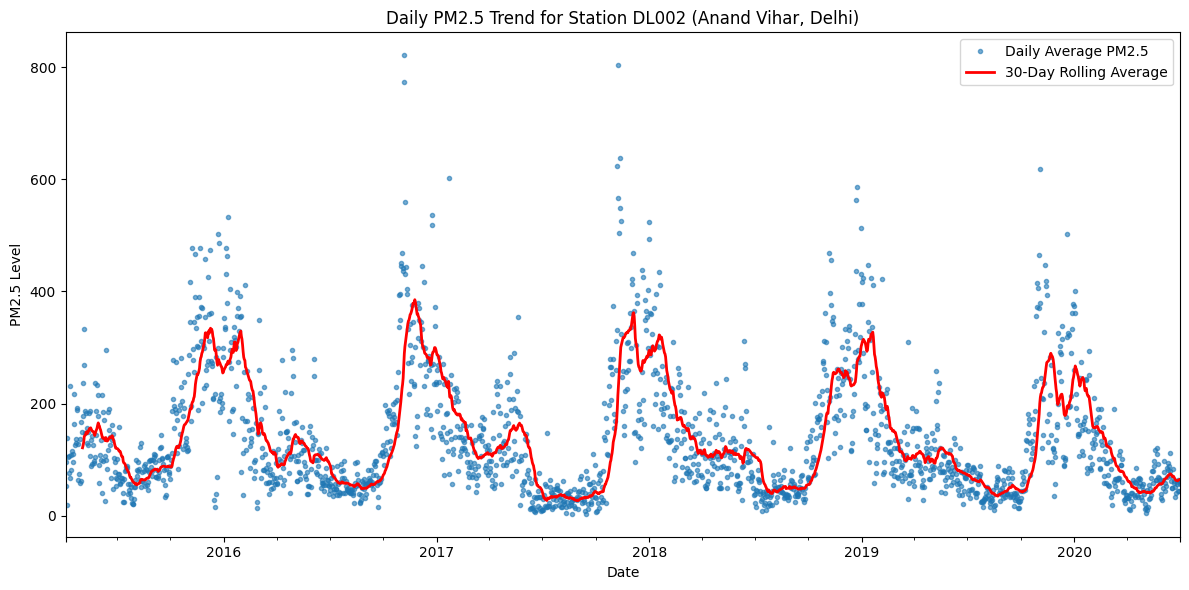

In [19]:
import matplotlib.pyplot as plt

# Plotting the daily average and a 30-day rolling average
plt.figure(figsize=(12, 6))
daily_avg.plot(label='Daily Average PM2.5', alpha=0.6, style='.')
rolling_avg.plot(label='30-Day Rolling Average', linewidth=2, color='red')

plt.title('Daily PM2.5 Trend for Station DL002 (Anand Vihar, Delhi)')
plt.xlabel('Date')
plt.ylabel('PM2.5 Level')
plt.legend()
plt.tight_layout()
plt.show()

### 5.4 Which stations are the cleanest?

In [20]:
valid_pm25 = station_daily_data[station_daily_data["PM2.5"] >0 ]

overall_avg = station_daily_data["PM2.5"].mean()

station_avg = valid_pm25.groupby("StationId")["PM2.5"].mean()

clean_stations = station_avg[station_avg < overall_avg].sort_values()
print(clean_stations.head())

StationId
MZ001    17.111593
KL002    24.741790
TN002    25.642216
KL008    29.203085
TN005    29.234378
Name: PM2.5, dtype: float64


## 6. Time-Series Visualization

### 6.1 What is the monthly PM2.5 trend in Delhi?
The line chart below visualizes the average PM2.5 level for each month in Delhi. This helps to clearly identify seasonal patterns in one of the country's major pollution hotspots.

In [21]:
# Creating a dataframe for Delhi's monthly PM2.5 average
# We use the clean city_day DataFrame as our source for this city-level analysis
delhi_df = city_day_cleaned[city_day_cleaned['City'] == 'Delhi'].copy()

# Create a column representing the month to group by
delhi_df['Month'] = delhi_df['Date'].dt.to_period('M')

# Group by the new 'Month' column and calculate the mean PM2.5
monthly_pm25 = delhi_df.groupby('Month')['PM2.5'].mean().reset_index()

# Convert the 'Month' period back to a timestamp for plotting
monthly_pm25['Month']  = monthly_pm25['Month'].dt.to_timestamp()

print("Created the 'monthly_pm25' DataFrame successfully.")

Created the 'monthly_pm25' DataFrame successfully.


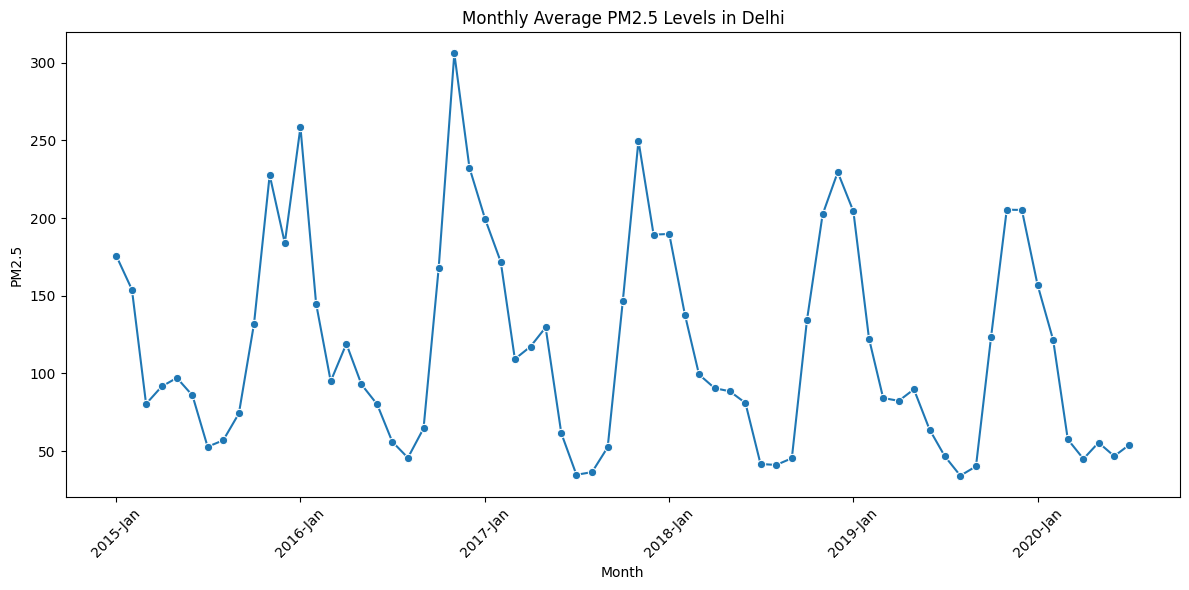

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='Month', y='PM2.5', data=monthly_pm25, marker='o') 

# Define the date format
date_format = DateFormatter("%Y-%b") 
ax.xaxis.set_major_formatter(date_format)

# Add titles and labels
plt.title("Monthly Average PM2.5 Levels in Delhi")
plt.xlabel('Month')
plt.ylabel('PM2.5')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Insight:** The plot reveals a strong and predictable seasonal pollution cycle in Delhi.
* **Peak Pollution:** PM2.5 levels begin to rise sharply in October, peaking during the winter months (December-January). This is likely due to meteorological factors like temperature inversions, which trap pollutants close to the ground, combined with increased sources like heating.
* **Cleanest Period:** Levels are lowest during the monsoon season (July-September), as heavy rains effectively wash particulate matter from the atmosphere.

### 6.2 Which cities are the best and worst performers?
This bar chart compares the average PM2.5 levels of the top 5 most polluted and top 5 least polluted cities from the dataset.

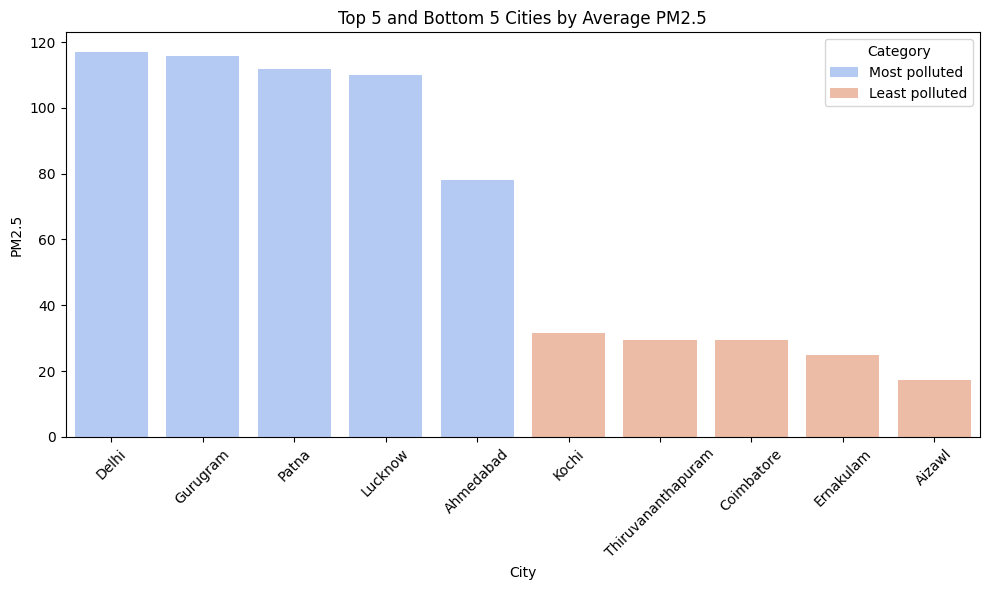

In [23]:
# top 5 and bottom 5 cities based on average PM2.5.
city_averagepm25 = city_day_cleaned.groupby('City')['PM2.5'].mean().sort_values(ascending=False)
# ------------------------------------

top5 = city_averagepm25.head(5)
bottom5 = city_averagepm25.tail(5)

# combining both for plotting
compare_df = pd.concat([top5, bottom5]).reset_index()

# label cities
compare_df['Category'] = ['Most polluted']*5 + ['Least polluted']*5

plt.figure(figsize=(10, 6))
sns.barplot(x='City', y='PM2.5', hue='Category', data=compare_df, dodge=False, palette='coolwarm')
plt.title('Top 5 and Bottom 5 Cities by Average PM2.5')
plt.xlabel('City')
plt.ylabel('PM2.5')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Insight:** This chart highlights three critical points about pollution in India:
1.  **Massive Disparity:** There is a huge gap in air quality between different regions. The average PM2.5 in the most polluted cities is over **4 times higher** than in the cleanest cities, indicating a severe public health divide.
2.  **Geographical Clustering:** The most polluted cities (Delhi,Gurugram, etc.) are predominantly located in the densely populated **Indo-Gangetic Plains**. The least polluted cities (like Aizawl) are in the Northeast, which benefits from different geography and weather patterns.
3.  **Chronic vs. Safe Air:** The average levels in the top cities fall into the "Poor" to "Very Poor" categories, meaning residents experience unhealthy air year-round. In contrast, the bottom cities enjoy air that is, on average, "Good" or "Satisfactory".

### 6.3 How does pollution vary by season across all cities?
To confirm the trend seen in Delhi on a national scale, this bar chart shows the average PM2.5 level aggregated by season across all available city data.

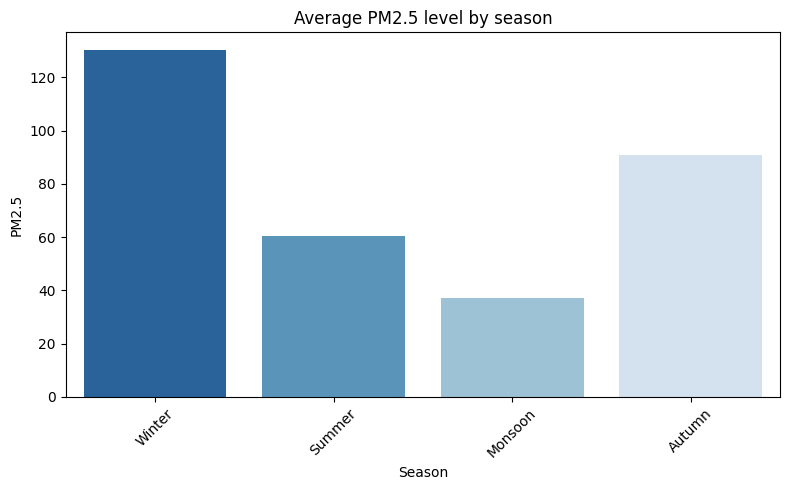

In [26]:
# finding how pollution varies by season- does it spike in winter(November-january) or drop in monsoon.

def get_season(month):
    if month in [11, 12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5, 6]:
        return 'Summer'
    elif month in [7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Autumn'

station_daily_data['Month'] = station_daily_data['Date'].dt.month
station_daily_data['Season'] = station_daily_data['Month'].apply(get_season)


seasonal_pm25 = station_daily_data.groupby('Season')['PM2.5'].mean().reset_index()

plt.figure(figsize = (8, 5))
sns.barplot(x = 'Season', y = 'PM2.5', data = seasonal_pm25, order= ['Winter', 'Summer', 'Monsoon', 'Autumn'], palette='Blues', hue= 'Season', legend= False)
plt.title('Average PM2.5 level by season')
plt.xlabel('Season')
plt.ylabel('PM2.5')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

**Insight:** This visualization confirms that the trend seen in Delhi is a nationwide phenomenon.
* **Winter Peak:** **Winter** is consistently the most polluted season across all cities. This national trend reinforces the idea that meteorology plays a major role, as colder, stagnant air traps pollutants across large areas.
* **Monsoon Relief:** The **Monsoon** provides a country-wide relief from air pollution, demonstrating the powerful cleansing effect of seasonal rainfall.

## 7. Conclusion

This analysis of India's air quality data from 2015-2020 revealed several key insights:

* **Geographical Disparity:** Geographical Disparity: Pollution is not uniform. A clear geographical trend shows that cities in the Indo-Gangetic Plain (like Gurugram, Delhi, and Patna) experience the most severe PM2.5 levels. While Ahmedabad (Gujarat) is also highly polluted, it ranks below the top cities in the northern plains.
* **Strong Seasonality:** There is a clear and predictable seasonal pattern in air pollution, with levels peaking in Winter and reaching their lowest during the Monsoon.
* **Methodology Matters:** The data cleaning process, particularly the choice to use interpolate(method= 'time') instead of a simple forward-fill (`ffill`), was crucial for achieving an accurate and realistic analysis of pollution trends.

---